Эпизод 1, Вознаграждение: -2520, Шаги: 5000
Эпизод 101, Вознаграждение: -1410, Шаги: 5000
Эпизод 201, Вознаграждение: -348, Шаги: 1077
Эпизод 301, Вознаграждение: 4, Шаги: 5000
Эпизод 401, Вознаграждение: -162, Шаги: 409
Эпизод 501, Вознаграждение: -1002, Шаги: 5000
Эпизод 601, Вознаграждение: -19, Шаги: 142
Эпизод 701, Вознаграждение: 46, Шаги: 5000
Эпизод 801, Вознаграждение: 560, Шаги: 5000
Эпизод 901, Вознаграждение: 444, Шаги: 5000


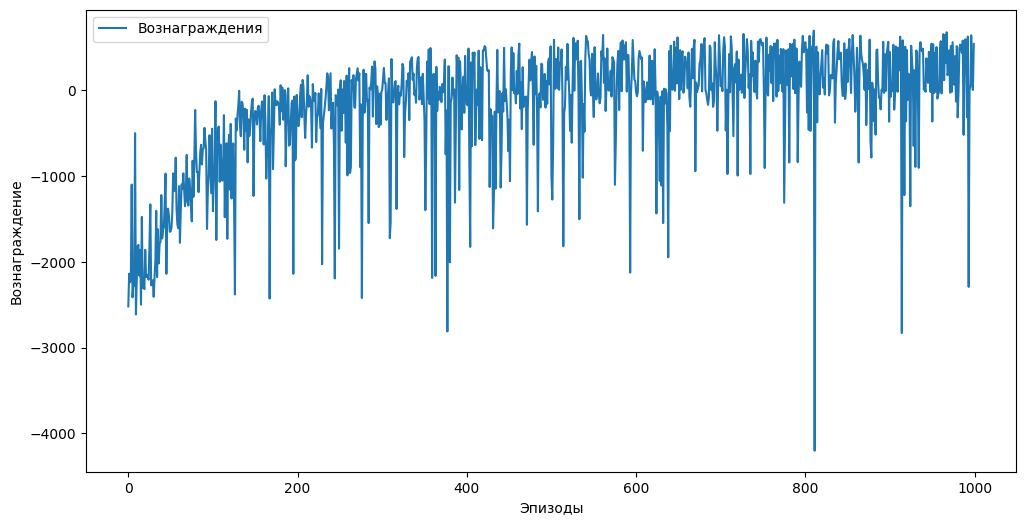

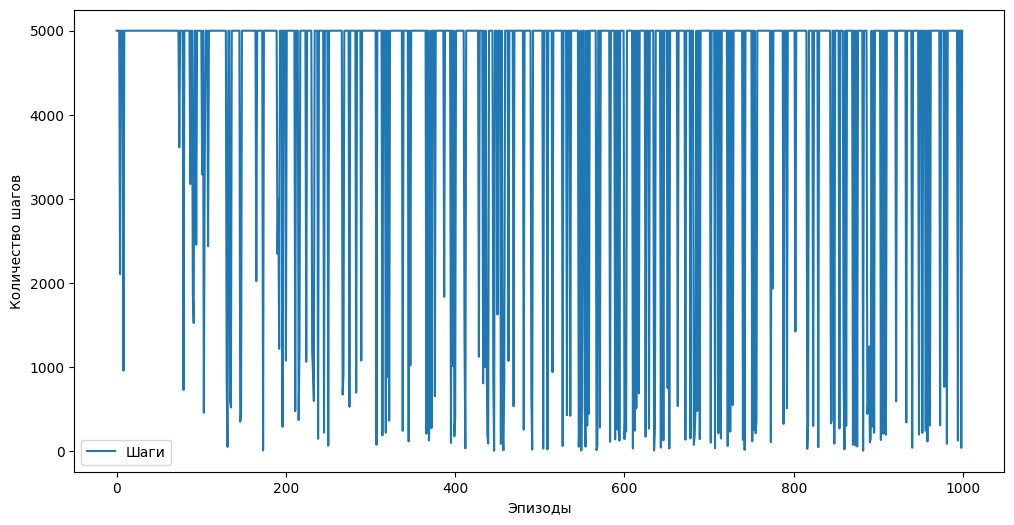

Среднее количество шагов (первые 100 эпизодов): 4764.23
Среднее количество шагов (последние 100 эпизодов): 4238.94


In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import os

# Установка начальных данных
num_glasses = 5
max_capacity = 10  # Максимальная емкость стаканов

# Функция для генерации случайного состояния стаканов
def generate_random_state():
    return np.array([random.randint(0, max_capacity) for _ in range(num_glasses)])

# Целевое количество жидкости в каждом стакане (среднее)
def target_amount(state):
    return np.mean(state)

# Действия агента: переливание жидкости между стаканами
def get_possible_actions(state):
    actions = []
    for i in range(num_glasses):
        for j in range(num_glasses):
            if i != j:
                actions.append((i, j))  # Перелить из стакана i в стакан j
    return actions

# Функция для применения действия с ограничением на количество жидкости
def apply_action(state, action):
    i, j = action
    amount_to_transfer = min(state[i], max_capacity - state[j], random.randint(1, 5))
    new_state = state.copy()
    new_state[i] -= amount_to_transfer
    new_state[j] += amount_to_transfer
    return new_state

# Функция для расчета вознаграждения
def calculate_reward(state, prev_state):
    target = target_amount(state)
    diff = np.abs(state - target)
    total_diff = np.sum(diff)

    prev_diff = np.sum(np.abs(prev_state - target))

    if total_diff == 0:
        return 10
    elif total_diff < prev_diff:
        return 1
    else:
        return -1

# Определение Q-learning агента
class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=0.9, save_path="q_table.pkl"):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.save_path = save_path
        self.q_table = self.load_q_table()
        self.reward_history = []
        self.step_history = []

    def get_state_key(self, state):
        return tuple(state)

    def choose_action(self, state):
        state_key = self.get_state_key(state)
        if random.uniform(0, 1) < self.epsilon or state_key not in self.q_table:
            return random.choice(get_possible_actions(state))
        else:
            q_values = [self.q_table[state_key].get(action, 0) for action in get_possible_actions(state)]
            max_q_value = max(q_values)
            max_actions = [action for action, q in zip(get_possible_actions(state), q_values) if q == max_q_value]
            return random.choice(max_actions)

    def update_q_value(self, state, action, reward, next_state):
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = {}
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {}

        best_next_q = max([self.q_table[next_state_key].get(a, 0) for a in get_possible_actions(next_state)])
        old_q_value = self.q_table[state_key].get(action, 0)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * best_next_q - old_q_value)
        self.q_table[state_key][action] = new_q_value

    def save_q_table(self):
        with open(self.save_path, "wb") as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self):
        if os.path.exists(self.save_path):
            with open(self.save_path, "rb") as f:
                return pickle.load(f)
        return {}

    def train(self, episodes=1000, max_steps_per_episode=5000):
        for episode in range(episodes):
            state = generate_random_state()
            total_reward = 0
            steps = 0
            prev_state = state.copy()

            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state = apply_action(state, action)
                reward = calculate_reward(next_state, prev_state)
                self.update_q_value(state, action, reward, next_state)

                total_reward += reward
                state = next_state
                prev_state = state.copy()
                steps += 1

                if np.sum(np.abs(state - target_amount(state))) == 0:
                    break

            self.epsilon = max(0.1, self.epsilon * 0.99)
            self.alpha = max(0.1, self.alpha * 0.99)

            self.reward_history.append(total_reward)
            self.step_history.append(steps)

            if episode % 20 == 0:
                self.save_q_table()

            if episode % 100 == 0:
                print(f"Эпизод {episode + 1}, Вознаграждение: {total_reward}, Шаги: {steps}")

        self.plot_training_progress()

    def plot_training_progress(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.reward_history, label="Вознаграждения")
        plt.xlabel("Эпизоды")
        plt.ylabel("Вознаграждение")
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.step_history, label="Шаги")
        plt.xlabel("Эпизоды")
        plt.ylabel("Количество шагов")
        plt.legend()
        plt.show()

        # Среднее количество шагов для первых и последних 100 эпизодов
        avg_steps_first_100 = np.mean(self.step_history[:100])
        avg_steps_last_100 = np.mean(self.step_history[-100:])
        print(f"Среднее количество шагов (первые 100 эпизодов): {avg_steps_first_100}")
        print(f"Среднее количество шагов (последние 100 эпизодов): {avg_steps_last_100}")

# Обучение агента
agent = QLearningAgent(epsilon=0.5, alpha=0.5)
agent.train(episodes=1000)
